LOADING DATA INTO THE NOTEBOOK

In [122]:
import pandas as pd

# Load company information
company_info = pd.read_csv('company_info.csv')

# Load company stock details
company_stock_details = pd.read_csv('company_stock_details.csv')

# Display the first few rows to understand the structure
print(company_info.head())
print(company_stock_details.head())

  Symbol  GICS Sector    Headquarters Location      Founded
0    MMM  Industrials    Saint Paul, Minnesota         1902
1    AOS  Industrials     Milwaukee, Wisconsin         1916
2    ABT  Health Care  North Chicago, Illinois         1888
3   ABBV  Health Care  North Chicago, Illinois  2013 (1888)
4   ABMD  Health Care   Danvers, Massachusetts         1981
        Date       Close   Volume Symbol  News - Positive Sentiment  \
0  30/9/2020  160.179993  3056900    MMM                        NaN   
1  1/10/2020  158.789993  1989100    MMM                        0.0   
2  2/10/2020  160.360001  1768600    MMM                        3.0   
3  5/10/2020  162.750000  1457000    MMM                        2.0   
4  6/10/2020  162.229996  2021900    MMM                        0.0   

   News - Negative Sentiment  News - New Products  News - Layoffs  \
0                        NaN                  NaN             NaN   
1                        0.0                  0.0             0.0   
2     

CLEAN DATA

In [123]:
print(company_info.isnull().sum())
print(company_stock_details.isnull().sum())

Symbol                   0
GICS Sector              0
Headquarters Location    0
Founded                  0
dtype: int64
Date                               0
Close                              0
Volume                             0
Symbol                             0
News - Positive Sentiment        493
News - Negative Sentiment        493
News - New Products              493
News - Layoffs                   493
News - Analyst Comments          493
News - Stocks                    493
News - Dividends                 493
News - Corporate Earnings        493
News - Mergers & Acquisitions    493
News - Store Openings            493
News - Product Recalls           493
News - Adverse Events            493
News - Personnel Changes         493
News - Stock Rumors              493
dtype: int64


HANDLING MISSING VALUES

In [124]:
company_stock_details.fillna(method='ffill', inplace=True)

C:\Users\alaga\AppData\Local\Temp\ipykernel_22796\2554499657.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_stock_details.fillna(method='ffill', inplace=True)


MERGING NEW DATA

In [125]:
# Perform an inner join to merge on 'Symbol' (this only keeps rows where there is a match)
merged_data = pd.merge(company_stock_details, company_info, on='Symbol', how='inner')

# Check the first few rows of the merged data
print(merged_data.head())

# Save the merged data into a new CSV file
merged_data.to_csv('merged_company_data.csv', index=False)

        Date       Close   Volume Symbol  News - Positive Sentiment  \
0  30/9/2020  160.179993  3056900    MMM                        NaN   
1  1/10/2020  158.789993  1989100    MMM                        0.0   
2  2/10/2020  160.360001  1768600    MMM                        3.0   
3  5/10/2020  162.750000  1457000    MMM                        2.0   
4  6/10/2020  162.229996  2021900    MMM                        0.0   

   News - Negative Sentiment  News - New Products  News - Layoffs  \
0                        NaN                  NaN             NaN   
1                        0.0                  0.0             0.0   
2                        0.0                  0.0             0.0   
3                        3.0                  0.0             0.0   
4                        0.0                  0.0             0.0   

   News - Analyst Comments  News - Stocks  ...  News - Corporate Earnings  \
0                      NaN            NaN  ...                        NaN   
1   

CREATING LAGGED VARIABLES


In [126]:
merged_data['Close_lag_1'] = merged_data.groupby('Symbol')['Close'].shift(1)
merged_data['Close_lag_2'] = merged_data.groupby('Symbol')['Close'].shift(2)
merged_data['Close_lag_3'] = merged_data.groupby('Symbol')['Close'].shift(3)
merged_data['Close_lag_4'] = merged_data.groupby('Symbol')['Close'].shift(4)
merged_data['Close_lag_5'] = merged_data.groupby('Symbol')['Close'].shift(5)

IMPROVING THEM FURTHER

In [127]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['Day'] = merged_data['Date'].dt.day
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Weekday'] = merged_data['Date'].dt.weekday

C:\Users\alaga\AppData\Local\Temp\ipykernel_22796\3375785028.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_data['Date'] = pd.to_datetime(merged_data['Date'])


TRAIN TEST SPLIT

In [128]:
# Sort by date to maintain chronological order
merged_data.sort_values(by=['Symbol', 'Date'], inplace=True)

# Define the split date
train_data = merged_data[merged_data['Date'] < '2022-01-01']
test_data = merged_data[merged_data['Date'] >= '2022-01-01']

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


LOADING UP FOR SARIMA

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

DOING PACF (ALSO ISOLATE TO JUST ONE COMPANY FIRST)

C:\Users\alaga\AppData\Local\Temp\ipykernel_22796\3920110932.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('company_stock_details.csv', parse_dates=['Date'], index_col='Date')


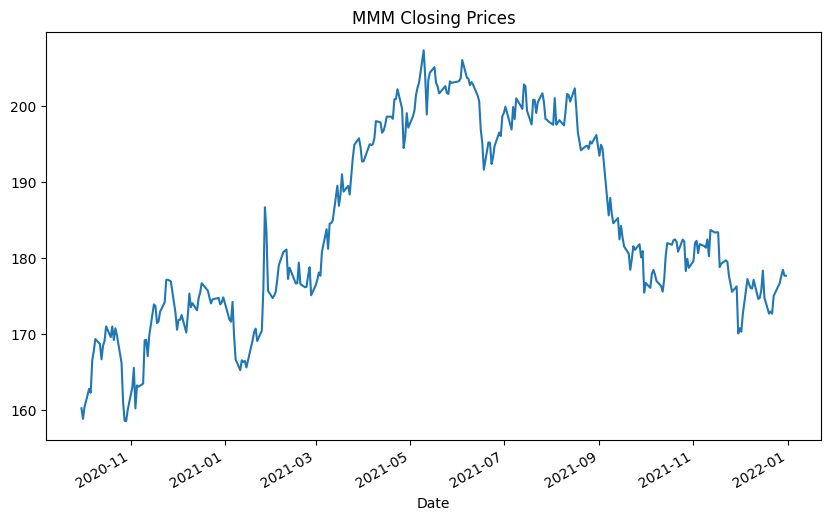

In [130]:
# Load the stock price data
data = pd.read_csv('company_stock_details.csv', parse_dates=['Date'], index_col='Date')
train_data = data[data.index < '2022-01-01']
# Filter for one company, for example 'MMM'
mmm_data = train_data[train_data['Symbol'] == 'MMM']

# Visualize the closing price over time
mmm_data['Close'].plot(title='MMM Closing Prices', figsize=(10, 6))
plt.show()

I am visually inferring that this data is not stationary looking at the graph, as the mean from 2020 october to 2022 january, is vastly different from the mean from 2022 january to 2022 july. Although, it is indeed worth mentioning that I think the standard deviation is constant, and I do not infer any direct seasonality from my naked eye. Regardless, let us test it out via code.

CHECKING STATIONARITY

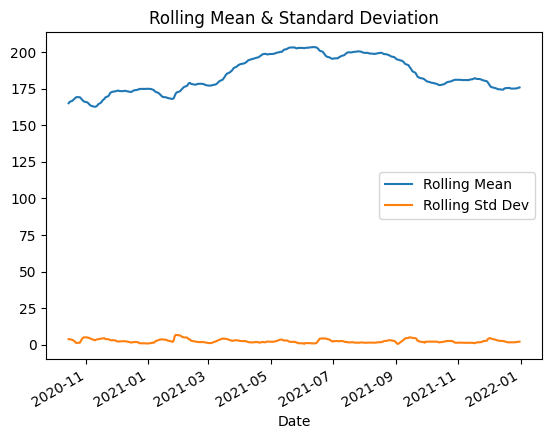

In [131]:
mmm_data['Close'].rolling(window=12).mean().plot(label='Rolling Mean')
mmm_data['Close'].rolling(window=12).std().plot(label='Rolling Std Dev')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

I used a rolling mean of 12 days, (after going past 12 datapoints, rolling mean uses the mean close of first 12 datapoints to create its first datapoint, then second datapoint is the 2nd to 13th datapoint, third datapoint is 3rd to 14th, so on so forth)

So I need to attempt to make this stationary, and how I will go about doing it is bringing forth the "integrated" aspect of ARIMA. Finding the differences between each datapoint, and then dropping the first difference as it is NA because it has no datapoint to difference off of, and plotting the differences instead.

C:\Users\alaga\AppData\Local\Temp\ipykernel_22796\4237357028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmm_data['Diff_Close'] = mmm_data['Close'].diff().dropna()


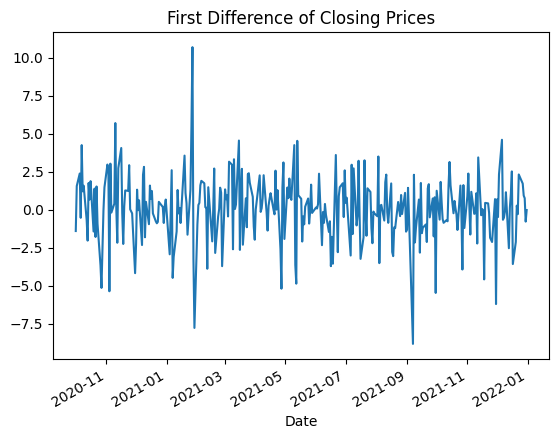

In [132]:
# Differencing the data
mmm_data['Diff_Close'] = mmm_data['Close'].diff().dropna()
mmm_data['Diff_Close'].plot(title='First Difference of Closing Prices')
plt.show()

This looks better stationarity wise.

PLOTTING PACF AND ACF

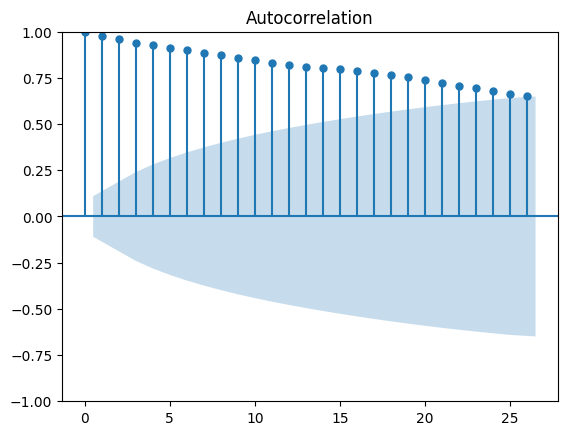

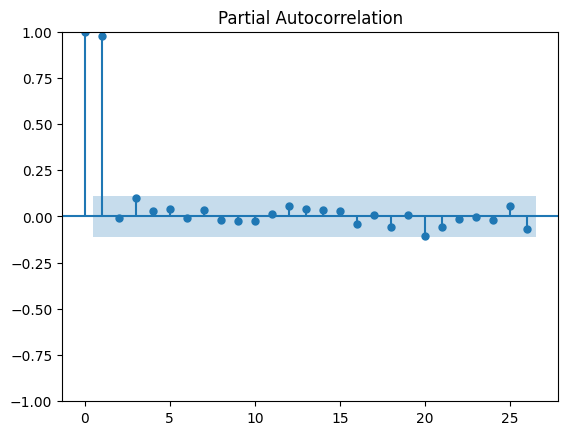

In [133]:
plot_acf(mmm_data['Close'].dropna())
plt.show()

plot_pacf(mmm_data['Close'].dropna())
plt.show()


I can conclude that this is an AR1 model, where we are basing the current variable with the most recent lagged variable.

However, in my learning curve while building this model, I have realised I need to confirm the non-stationarity of the data. Hence, I ran an Augmented Dickey Fuller test, to check whether the co-efficient I obtained off of the PACF test for the most recent lagged variable, is an unit root or not. If it is an unit root, meaning it equals to 1, that 

In [134]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'Close' prices
adf_result = adfuller(mmm_data['Close'])

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary (cannot reject null hypothesis).")
else:
    print("The time series is likely stationary (reject null hypothesis).")

ADF Statistic: -1.982859340445174
p-value: 0.29413888031519664
Critical Values: {'1%': np.float64(-3.4513486122290717), '5%': np.float64(-2.870789013306053), '10%': np.float64(-2.5716978530569192)}
The time series is likely non-stationary (cannot reject null hypothesis).


I also wanted to literally find the co-efficient of the most recent lagged variable under partial auto correlation to check whether it has an unit root or not.

In [135]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AutoRegressive (AR) model to the closing prices
# The 'lags' parameter controls how many lagged terms to include (for example, AR(1) or AR(2))
ar_model = AutoReg(mmm_data['Close'], lags=1).fit()

# Print the AR coefficient(s) (rho values)
print("AR coefficients (rho):")
print(ar_model.params)



AR coefficients (rho):
const       3.796147
Close.L1    0.979670
dtype: float64


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


I want to run a "white noise" test using the auto-regressive model result that I got to check whether the residual, or also known as the actual value minus the predicted value, gives me a white noise graph, where the mean of the white noise graph is 0, the standard deviation is constant with time, and there are no correlation between the lags

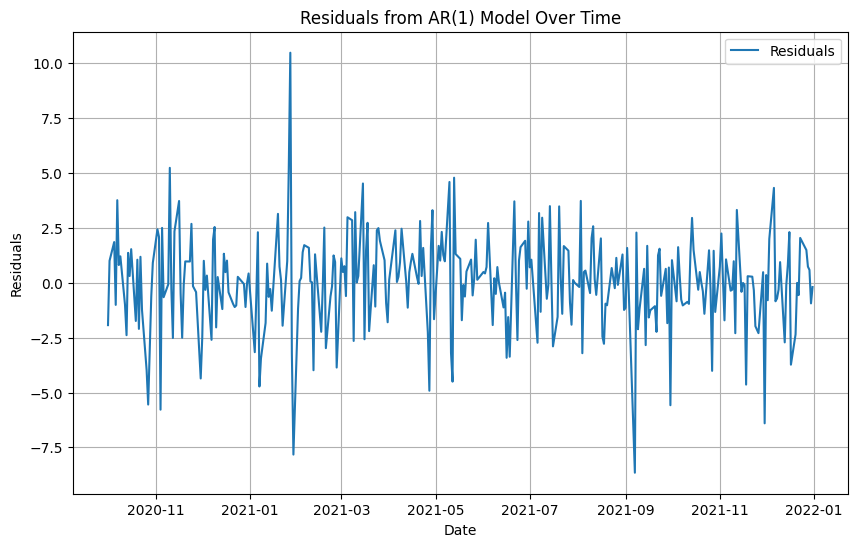

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  9.484743   0.486798
The residuals appear to be white noise (fail to reject null hypothesis).


In [136]:
# Get the residuals of the AR model
residuals = ar_model.resid

# Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.title('Residuals from AR(1) Model Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Run Ljung-Box test to check if residuals are white noise
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

# Print the results of the Ljung-Box test
print("Ljung-Box Test Results:")
print(ljung_box_test)

if ljung_box_test['lb_pvalue'].values[0] > 0.05:
    print("The residuals appear to be white noise (fail to reject null hypothesis).")
else:
    print("The residuals do not appear to be white noise (reject null hypothesis).")

In [137]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs(residuals) / closing_prices[1:]).mean() * 100

# Print the MAPE result
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 0.87%


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in

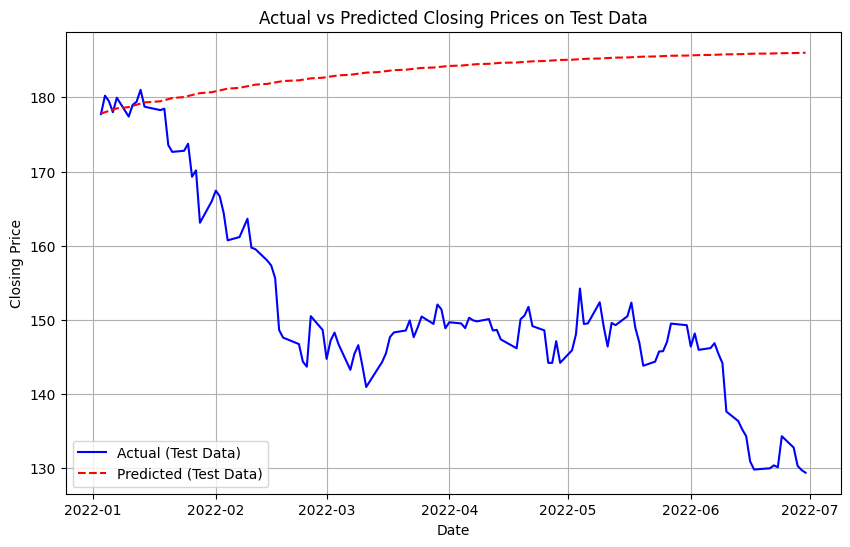

Mean Absolute Percentage Error (MAPE) on Test Data: 21.86%


In [138]:
# Split the data into train and test based on the date
train_data = data[data.index < '2022-01-01']
test_data = data[data.index >= '2022-01-01']

# Filter for one company, for example 'MMM'
train_mmm_data = train_data[train_data['Symbol'] == 'MMM']
test_mmm_data = test_data[test_data['Symbol'] == 'MMM']

# Train AutoRegressive (AR) model using the training data
closing_prices_train = train_mmm_data['Close']
ar_model = AutoReg(closing_prices_train, lags=1).fit()

# Predict the test data
# Note: The start and end indices for predict must match the test data range
predicted_values = ar_model.predict(start=len(closing_prices_train), 
                                    end=len(closing_prices_train) + len(test_mmm_data) - 1, 
                                    dynamic=False)

# Align the predicted values with the test set's index
predicted_values.index = test_mmm_data.index

# Plot actual vs predicted values on test data
plt.figure(figsize=(10, 6))

# Plot actual closing prices from test data
plt.plot(test_mmm_data.index, test_mmm_data['Close'], label='Actual (Test Data)', color='blue')

# Plot predicted closing prices from test data
plt.plot(predicted_values.index, predicted_values, label='Predicted (Test Data)', color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Closing Prices on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Optionally, calculate Mean Absolute Percentage Error (MAPE) on test data
residuals = test_mmm_data['Close'] - predicted_values
mape = (abs(residuals) / test_mmm_data['Close']).mean() * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Data: {mape:.2f}%")

From above, we find out train test split might not be a good way to test out the evaluative performance on our auto-regressive model. This is because while maybe our predictions did better at the start, as time goes on, we are not really doing as well. Uncertainty increases with time. Which is why it might make sense to do a rolling evaluation. Predict for the next day, then add that next day data into training set, predict for the next next day, add that next next day data into training set, so on and so forth, to evaluate the model while accounting for the uncertainty condition. THIS IS CALLED ROLLING FORECAST ORIGIN.

C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Temp\ipykernel_22796\2863808629.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_prediction = ar_model.predict(start=history.index[-1], end=history.index[-1])[0]
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency info

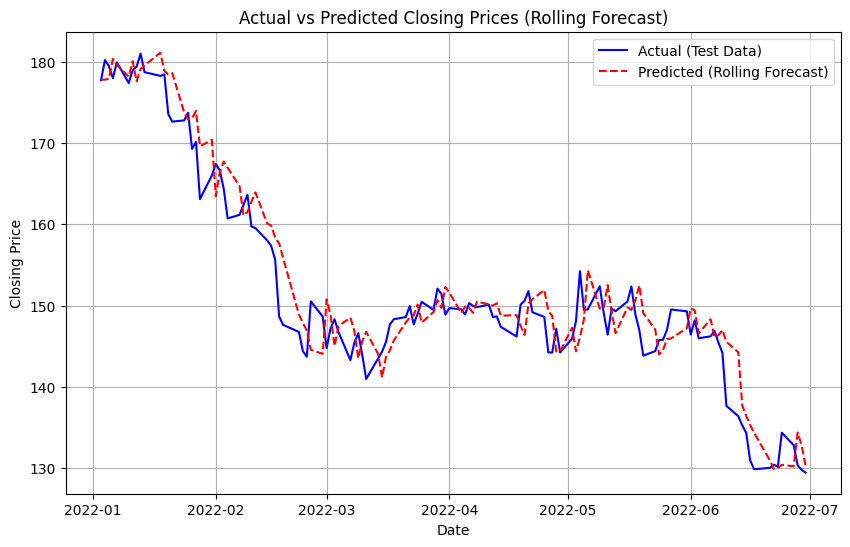

Mean Absolute Percentage Error (MAPE) with Rolling Forecast: 1.77%


In [139]:
# Use closing prices for training and test data
closing_prices_train = train_mmm_data['Close']
closing_prices_test = test_mmm_data['Close']

# Initialize a list to store predictions
rolling_predictions = []

# Start rolling forecast
history = closing_prices_train.copy()  # Initial training data

for t in range(len(closing_prices_test)):
    # Fit the model using the current training data (history)
    ar_model = AutoReg(history, lags=1).fit()

    # Predict the next value (one step ahead)
    next_prediction = ar_model.predict(start=history.index[-1], end=history.index[-1])[0]

    # Append the prediction to the list
    rolling_predictions.append(next_prediction)

    # Add the actual test data point to the history (walk-forward)
    history = pd.concat([history, pd.Series(closing_prices_test.iloc[t], index=[closing_prices_test.index[t]])])

# Convert rolling predictions to a pandas series for plotting
rolling_predictions = pd.Series(rolling_predictions, index=closing_prices_test.index)

# Plot actual vs predicted values on test data
plt.figure(figsize=(10, 6))

# Plot actual closing prices from test data
plt.plot(closing_prices_test.index, closing_prices_test, label='Actual (Test Data)', color='blue')

# Plot rolling forecast predictions
plt.plot(rolling_predictions.index, rolling_predictions, label='Predicted (Rolling Forecast)', color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Closing Prices (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Optionally, calculate Mean Absolute Percentage Error (MAPE) on test data
residuals = closing_prices_test - rolling_predictions
mape = (abs(residuals) / closing_prices_test).mean() * 100
print(f"Mean Absolute Percentage Error (MAPE) with Rolling Forecast: {mape:.2f}%")

This is pretty good, right? We are able to predict with just 1.77% error. However, I tried doing a simulation experiment where we followed this model predictions to make trades accordingly. The strategy is to invest and long the 10000 dollars worth of MMM stock if the predicted price tomorrow were to increase from today, or to divest and short the 10000 dollars worth of MMM stock if the predicted price tomorrow were to decrease from today.

In [140]:
# Starting capital
initial_capital = 10000
capital = initial_capital

# Store all profits or losses for each trade
trade_results = []

# Assume no position at the beginning
position = None  # 'long' or 'short'
entry_price = 0

# Simulate trades
for i in range(1, len(test_mmm_data)):
    actual_today = closing_prices_test.iloc[i-1]
    actual_tomorrow = closing_prices_test.iloc[i]
    predicted_today = rolling_predictions.iloc[i-1]
    predicted_tomorrow = rolling_predictions.iloc[i]
    
    # Determine trade direction based on predicted prices
    if predicted_tomorrow > predicted_today:  # Predicted price increase -> Go Long
        if position != 'long':  # Enter a long position
            position = 'long'
            entry_price = actual_today
        # Calculate profit/loss if the position is closed
        if i == len(test_mmm_data) - 1 or rolling_predictions.iloc[i+1] < predicted_tomorrow:  # Close position at the end or predicted decrease
            profit = (actual_tomorrow - entry_price) / entry_price * capital
            trade_results.append(profit)
            capital += profit  # Update capital
            position = None  # Close position
    elif predicted_tomorrow < predicted_today:  # Predicted price decrease -> Go Short
        if position != 'short':  # Enter a short position
            position = 'short'
            entry_price = actual_today
        # Calculate profit/loss if the position is closed
        if i == len(test_mmm_data) - 1 or rolling_predictions.iloc[i+1] > predicted_tomorrow:  # Close position at the end or predicted increase
            profit = (entry_price - actual_tomorrow) / entry_price * capital
            trade_results.append(profit)
            capital += profit  # Update capital
            position = None  # Close position

# Final capital after all trades
final_capital = capital

# Profit or loss summary
total_profit_or_loss = final_capital - initial_capital
percentage_return = (total_profit_or_loss / initial_capital) * 100

print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${final_capital:.2f}")
print(f"Total Profit/Loss: ${total_profit_or_loss:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")

Initial Capital: $10000.00
Final Capital: $8603.38
Total Profit/Loss: $-1396.62
Percentage Return: -13.97%


The result was that we lost 1396 dollars! How come? This is because MAPE does not give us the directional accuracy of this model, and simply only gives us the percentage of the residual as a proportion of the actual data, and this residual is absolute, so devoid of direction. However, when it comes to trading, direction matters a lot, and hence I made another function that finds out the directional accuracy of this model, meaning how many times it predicted in the correct direction in a measure of percentage upon the sample space of how many actual test data there are.

In [141]:
# Calculate directional accuracy (whether the predicted direction matches actual direction)
correct_direction = (rolling_predictions.diff().dropna().apply(lambda x: 1 if x > 0 else -1) == closing_prices_test.diff().dropna().apply(lambda x: 1 if x > 0 else -1))

# Calculate percentage of correct predictions in terms of direction
directional_accuracy = correct_direction.mean() * 100
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

Directional Accuracy: 44.72%


Hence, directional accuracy wise, this model is not amazing because it only predicts in the correct direction error 44% of the time. I attempted to use another evaluator function that combines the MAPE and directional accuracy to test out how reliable the model is, which is hybrid directional symmetry. It gives a score between 0 and 1, where 1 means it is a perfect model, 0 means it is a really really poor model.

In [142]:
# Calculate MAPE
mape = (abs(closing_prices_test - rolling_predictions) / closing_prices_test).mean()

# Calculate directional accuracy
predicted_movements = rolling_predictions.diff().dropna()
actual_movements = closing_prices_test.diff().dropna()

correct_direction = (predicted_movements.apply(lambda x: 1 if x > 0 else -1) == actual_movements.apply(lambda x: 1 if x > 0 else -1))
directional_accuracy = correct_direction.mean()

# Hybrid Directional Symmetry (HDS)
hds = (1 - mape) * directional_accuracy

print(f"MAPE: {mape * 100:.2f}%")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")
print(f"Hybrid Directional Symmetry (HDS): {hds:.2f}")

MAPE: 1.77%
Directional Accuracy: 44.72%
Hybrid Directional Symmetry (HDS): 0.44
